# Arize Tutorial: Weights & Biases Integration

Let's get started on using Arize with W&B! ✨

Arize helps you visualize your model performance, understand drift & data quality issues, and share insights learned from your models. Weights & Biases helps you track, compare, and visualize ML experiments and manage dataset or model versioning. Integrating Arize with Wandb allows you to track and explain model performance during training, validation, and production, as well as quickly serving the best performing model in training experiments.


## Running This Notebook
1. Save a copy in Google Drive for yourself.
2. Step through each section below, pressing play on the code blocks to run the cells.
4. Log in your browser to wandb
3. In Step 4, use your own Space and API key from your Arize account.

## Step 1: Data Loading
We will be working with a `tensorflow.keras` model to build a model for  classifying whether an individual has breast cancer or not!

In [1]:
!pip install shap -q
import numpy as np
import pandas as pd
import uuid
import os
import shap
import concurrent.futures as cf
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
import datetime

def process_data(X, y):
    scaler = preprocessing.MinMaxScaler()
    X = np.array(X).reshape((len(X), 30))
    y = np.array(y)
    return X, y

# 1 Load data and split data
data = datasets.load_breast_cancer()

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = X.astype(np.float32), y

X, y = pd.DataFrame(X, columns=data['feature_names']), pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42)

print('Step 1 ✅: Load Data Done!')

Step 1 ✅: Load Data Done!


## Step 2: Import and Setup Arize Client
You can find your `API_KEY` and `SPACE_KEY` by navigating to the settings page in your workspace (only space admins can see the keys). Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.
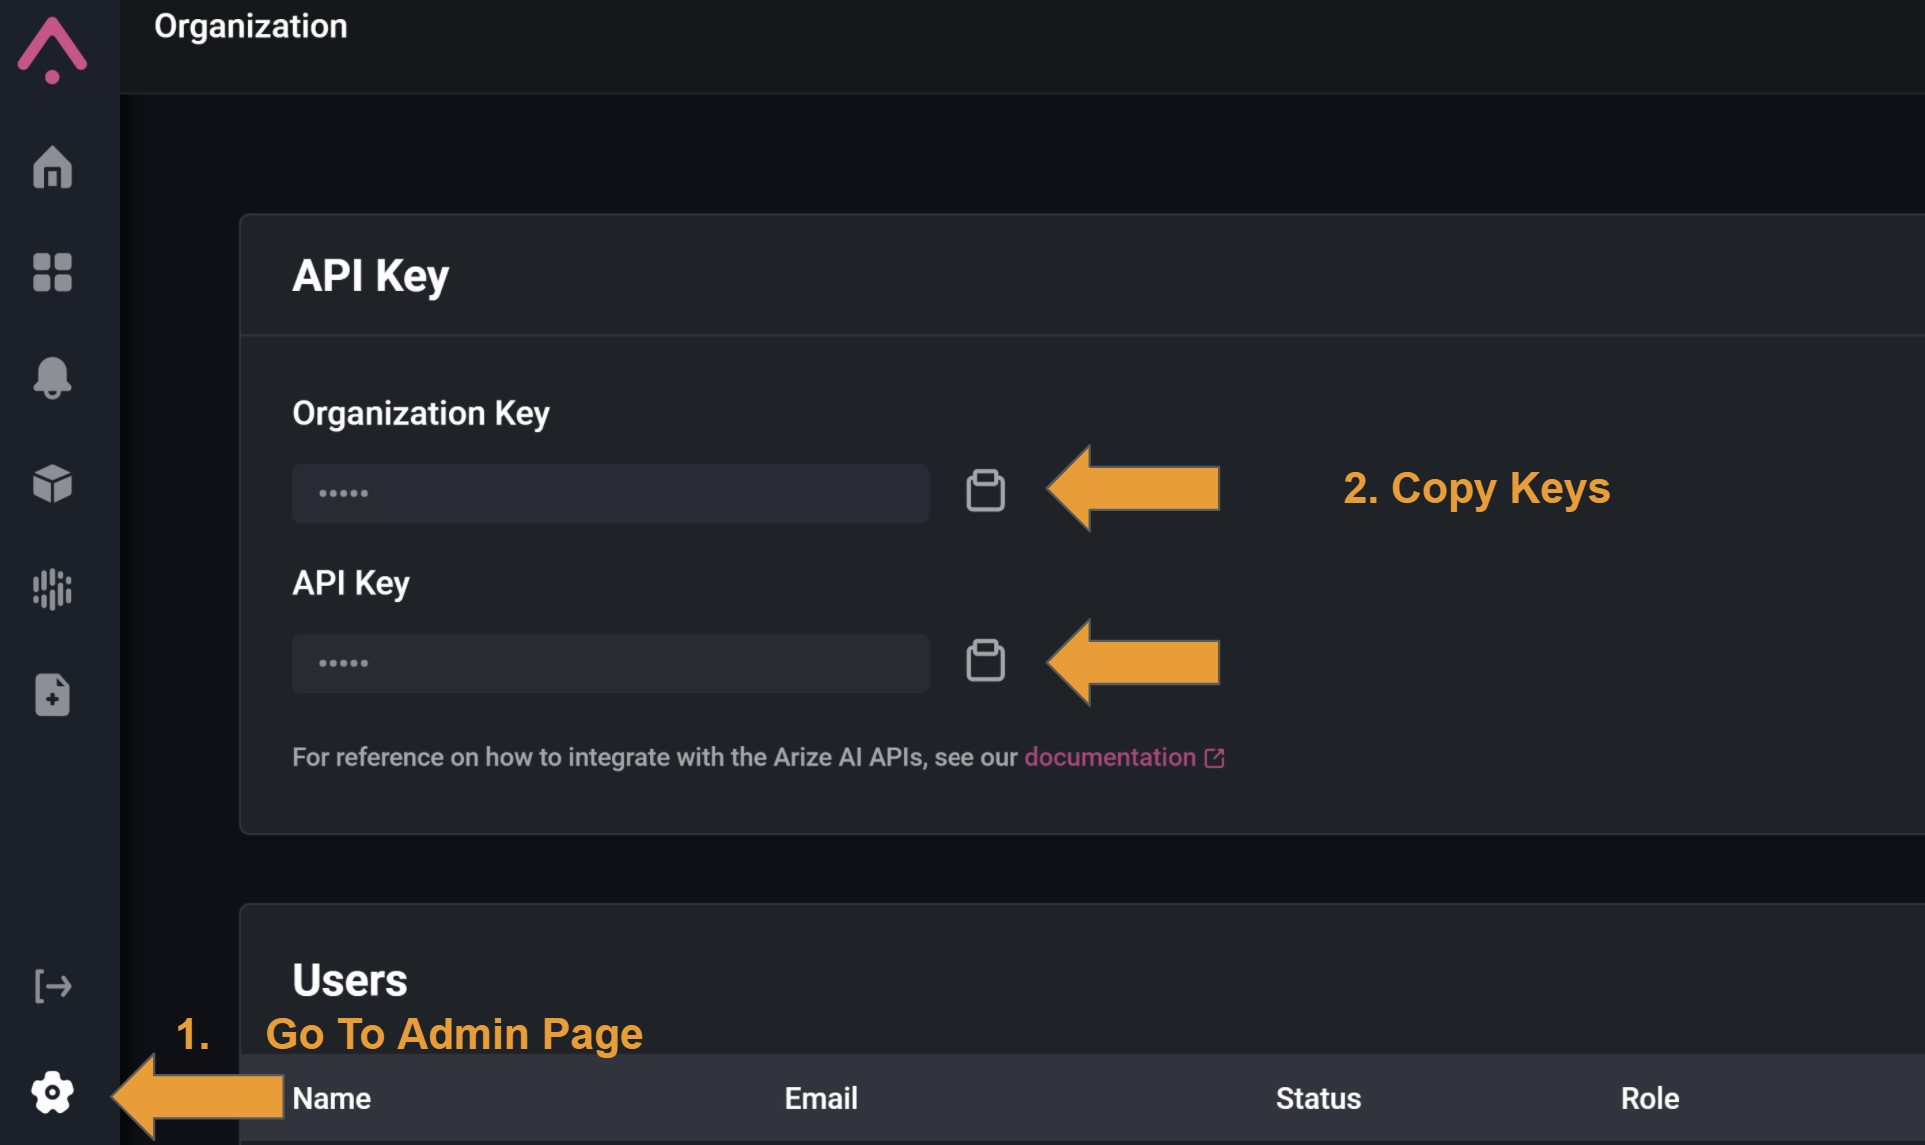

In [2]:
!pip install arize -q
from arize.api import Client
from arize.utils.types import ModelTypes

SPACE_KEY = 'YOUR_SPACE_KEY'
API_KEY = 'YOUR_API_KEY'
arize = Client(space_key=SPACE_KEY, api_key=API_KEY)

model_id = 'wandb_breast_cancer_prediction'
model_version = '1.0'
model_type = ModelTypes.BINARY

print('Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!')

     |████████████████████████████████| 1.3MB 3.9MB/s 
     |████████████████████████████████| 286kB 17.8MB/s 
ERROR: tensorflow-metadata 1.0.0 has requirement googleapis-common-protos<2,>=1.52.0, but you'll have googleapis-common-protos 1.51.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
Step 2 ✅: Import and Setup Arize Client Done! Now we can start using Arize!


## Step 3: Logging Training Callbacks with W&B

We can log training callbacks, sessions, and experiments with `wandb`. For `tensorflow.keras`, this is done automatically with `WandbCallback`

In [ ]:
!pip install wandb -q
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from wandb.keras import WandbCallback
import tensorflow as tf
import wandb

wandb.init(project='keras-model')

# Step 1: Define and compile model
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_shape=((30,))))
model.add(Dropout(0.25))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.mean_squared_logarithmic_error)

# Step 2: Fit model and log callbacks
model.fit(X_train, y_train, batch_size=30, epochs=50, verbose=0, validation_data=(X_test, y_test),
          callbacks=[WandbCallback()]
          )

# Step 3: Evaluate validation accuracy
loss = model.evaluate(X_val, y_val, verbose=1, batch_size=30)
print("Validation accuracy is {}".format(100 - loss*100))

print('Step 3 ✅: Model fitting and training call back logging complete!')

## Step 4: Logging Training Inferences with Arize


In [4]:
# OPTIONAL: Helper to listen to response code to ensure successful delivery
def arize_responses_helper(responses):
    """
    Helper function for checking arize responses for both bulk and non-bulk
    """
    def check_result(response):
        res = response.result()
        assert res.status_code == 200, f'future failed with response code {res.status_code}, {res.text}'
    if type(responses) != list:
        check_result(responses)
    else:
        for response in cf.as_completed(responses):
            check_result(response)

In [5]:
# Use the model to generate predictions
y_train_pred = model.predict(X_train).T[0]
y_val_pred = model.predict(X_val).T[0]
y_test_pred = model.predict(X_test).T[0]

# Logging training
train_prediction_labels = pd.Series(y_train_pred)
train_actual_labels = pd.Series(y_train)
train_feature_df = pd.DataFrame(X_train, columns=data['feature_names'])

train_responses = arize.log_training_records(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type, # this will change depending on your model type
    prediction_labels=train_prediction_labels,
    actual_labels=train_actual_labels,
    features=train_feature_df,
    )

arize_responses_helper(train_responses)

print('Step 4 ✅: If no errors showed up, you have sent Training Inferences!')

Step 4 ✅: If no errors showed up, you have sent Training Inferences!


## Step 5: Logging Validation Inferences with Arize

In [6]:
val_prediction_labels = pd.Series(y_val_pred)
val_actual_labels = pd.Series(y_val)
val_features_df = pd.DataFrame(X_val, columns=data['feature_names'])

val_responses = arize.log_validation_records(
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    batch_id='batch0',
    prediction_labels=val_prediction_labels,
    actual_labels=val_actual_labels,
    features=val_features_df,
    )

arize_responses_helper(val_responses)
print('Step 5 ✅: If no errors showed up, you have sent Validation Inferences!')

Step 5 ✅: If no errors showed up, you have sent Validation Inferences!


## Step 6: Saving & Loading Best Model with W&B
After storing your best model from experiments, you can save and load your model directly with Weights & Biases

In [7]:
# 1 "model.h5" is saved in wandb.run.dir & will be uploaded at the end of training
model.save(os.path.join(wandb.run.dir, "model.h5"))
wandb.save('model.h5')

# 2 Using wandb to restore the model
best_model = wandb.restore('model.h5')
model.load_weights(best_model.name)

loss = model.evaluate(X_test, y_test, verbose=1, batch_size=30)
print("Test accuracy from wandb loaded model is {}".format(100 - loss*100))
print('Step 6 ✅: If no errors showed up, you have successfully loaded the saved model from W&B!')

5/5 [==============================] - 0s 2ms/step - loss: 0.0652
Test accuracy from wandb loaded model is 93.48145052790642
Step 6 ✅: If no errors showed up, you have successfully loaded the saved model from W&B!


## Step 7: Production Logging & Monitoring with Arize

In [8]:
import datetime

# OPTIONAL: We can manually specify when records are made
def simulate_production_timestamps(num_entries, days=30):
    """
    Takes in: number of entries used for bulk_log, and number of days we want simulate back trace
    Returns prediction_timestamps arguement for bulk_log, uniformally distributed over time period
    """
    current_time = datetime.datetime.now().timestamp()
    earlier_time = (datetime.datetime.now() - datetime.timedelta(days=days)).timestamp()
    optional_prediction_timestamp = np.linspace(earlier_time, current_time, num=num_entries)
    optional_prediction_timestamp = pd.Series(optional_prediction_timestamp.astype(int))
    return optional_prediction_timestamp

# Generating Predictions
y_test_pred = pd.Series(y_test_pred)
num_preds = len(y_test_pred) # num_preds == 143

# Generating Prediction IDs
ids_df = pd.DataFrame([str(uuid.uuid4()) for _ in range(num_preds)])

# Generating simulated prediction_timestamps over 30 days
optional_prediction_timestamps = simulate_production_timestamps(len(y_test_pred), days=30)

# Logging the Predictions, Features, and Actuals only! (note: Features are optional too)
log_predictions_responses = arize.bulk_log(
    # Required arguments below
    model_id=model_id,
    prediction_ids=ids_df,
    # Optional arguments
    model_version=model_version,
    prediction_labels=y_test_pred,
    actual_labels=y_test,
    features=X_test, # we recommend logging features with predictions
    model_type=model_type, # we recommend using model_type on first time logging to Arize
    feature_names_overwrite=None,
    prediction_timestamps=optional_prediction_timestamps # OPTIONAL: simulating production timeline
    )

arize_responses_helper(log_predictions_responses)
print('Step 7 ✅: If no errors appear, you just logged {} total predictions, features, and shap values to Arize!'.format(num_preds))

Step 7 ✅: If no errors appear, you just logged 143 total predictions, features, and shap values to Arize!


### Overview
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
